# PageRank

In this notebook, we'll cover an implementation of the basic PageRank algorithm. In the example here, we will be working exclusively with a directed graphs.

PageRank was developed originally at Google by Larry Page and Sergey Brin. This algorithm is famous for being the original basis for the Google Search Engine. See: https://www.cis.upenn.edu/~mkearns/teaching/NetworkedLife/pagerank.pdf?ref=ruky.me

https://insidelearningmachines.com/learn_the_pagerank_algorithm/

In [1]:
pip install scikit-network

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.6 MB/s eta 0:00:00


In [2]:
import sknetwork as skn
import numpy as np
from typing import Tuple, List
from IPython.display import SVG

In [5]:
edges = [("A", "B"),("B", "D"),("D", "A"),("D","C"),("A", "C"),("C", "A"),("D","E"),("F","D")]

In [ ]:
graph = skn.data.from_edge_list(edges, directed=True)

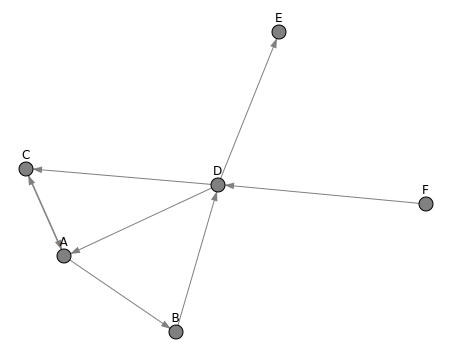

In [ ]:
image = skn.visualization.graphs.visualize_graph(adjacency=graph.adjacency, names=graph.names, name_position='above')
SVG(image)

## First Attempt: Simplified Approach

To gain some intuition, let's first work through a basic version of the algorithm. We will create an iterative procedure, that will function as follows:
* initialize all nodes in the graph to have the same rank value $= 1/(\text{number of nodes in the graph})$
* on each iteration, transfer the rank value from the source node to destination node in proportion to the number of out-edges from the source node

To express how rank value $P_r$ is transferred mathematically:

$P_r(p_i) = \sum_{\text{edges}_{ji}} \frac{P_r(p_j)}{O_{j}}$

where $p$ represents the pages/nodes in our graph, $i$ indexes over the destination nodes, $j$ indexes over the source nodes, and $O$ is a count of all the outlinks from the $j^{th}$ source node. We compute the above ratio and sum over all existing edges that run from $j$ to $i$.

### Problems with the Simplified Approach

Nodes E and F represent problems for the simplified algorithm presented above. Node E is a sink, where it only has an input edge directed towards it. As a consequence, rank value will tend to to be lost at this node over successive iterations in the algorithm. For node F, which is a source node, on the first iteration the assigned rank value for F will be granted to node D, and F will be left with a value of 0.

This doesn't seem to be sensible treatment for source or sink nodes. Let's make a somewhat more sophisticated algorithm, to handle nodes like E & F!

## A More Sophisticated Approach: Introducing the Damping Factor

We can make a more realistic model by introducing a *damping factor* $d$, that is the probability a user will follow a link on page $p_j$ to page $p_i$. Conversely, $1-d$ is termed the *fly-out probability*, which is the chance a user will select a new page at random (i.e. will not follow an edge in the graph). With the inclusion of $d$, it is now possible to move past node E after landing on it, and it is possible to arrive back at F after leaving it.

Mathematically, we can include the damping factor in the following way:

$P_r(p_i) = d\sum_{\text{edges}_{ji}} \frac{P_r(p_j)}{O_{j}} + \frac{1-d}{N_p}$

where $N_p$ is the total number of pages/nodes in the graph.

## The Algorithm

We can now write out the algorithm we will follow here for each iteration $t=0,1,2,...$:

1. Initialize the rank values for all pages $P_r(p_i; t)$ in the graph at $t=0$ with: $P_r(p_i; 0)=\frac{1}{N_p}$
2. For $t=1,2,3,...$ update the rank values with $P_r(p_i;t+1) = d\sum_{\text{edges}_{ji}} \frac{P_r(p_j;t)}{O_{j}} + \frac{1-d}{N_p}$

Let's write things more compactly, by writing a matrix equation using the following objects:

${\bf P_r(t)} = \begin{bmatrix} P_r(p_0;t) \\ P_r(p_1;t) \\ \vdots \\ P_r(p_{N_p};t) \end{bmatrix}$

${\bf D} = \begin{bmatrix} 1/D_{0,0} && 0 && \cdots && 0 \\
                           0 && 1/D_{1,1} &&        && \vdots \\
                            \vdots    &&           && \ddots &&        \\
                           0 && \cdots  &&        && 1/D_{N_p,N_p} \end{bmatrix}$

${\bf O} = \begin{bmatrix} O_{0,0} && O_{0,1} && \cdots && O_{0,N_p} \\
                           O_{1,0} && O_{1,1} &&        && \vdots \\
                           \vdots    &&           && \ddots &&        \\
                           O_{N_p,0} && \cdots  &&        && O_{N_p,N_p} \end{bmatrix}$

${\bf \hat{O}} = {\bf OD}$

Here we have:
* ${\bf P_r(t)}$ is a column vector containing all the page ranks at step $t$
* ${\bf D}$ is a square diagonal matrix, where each element along the diagonal is either the inverse of the out-degree of node $i$, or $0.0$ if there are no outgoing edges
* ${\bf O}$ is the square adacency matrix for the graph
* ${\bf \hat{O}}$ is a modified form of the adacency matrix, where each element $\hat{O}_{i,j}$ is the ratio of edges from $j \rightarrow i$ divided by the total out-degree of node $j$
* each column in ${\bf \hat{O}}$ is normalized to sum to 1.0

Now we can rewrite the PageRank update at $t+1$ as:

${\bf P_r(t+1)} = d{\bf \hat{O}P_r(t)} + \frac{1-d}{N_p}{\bf 1}$

where the column vector ${\bf 1}$ consists of $N_p$ elements all set to 1.0.

We can continue updating until convergence is reached as set by $\epsilon$:

$|{\bf P_r(t+1)} - {\bf P_r(t)}| < \epsilon$

## Implementation

Let's now proceed to implement the algorithm covered above:

In [ ]:
class Graph(object):

    def __init__(self, edges: List[Tuple]) -> None:
        # Khởi tạo đối tượng Graph
        nodes = set()  # Tập hợp các node duy nhất trong đồ thị
        indegrees = {}  # Từ điển lưu số lượng cạnh vào của mỗi node
        outdegrees = {}  # Từ điển lưu số lượng cạnh ra của mỗi node

        # Duyệt qua các cạnh để xác định tập hợp node và tính số cạnh ra, cạnh vào
        for edge in edges:
            nodes.update(list(edge))  # Cập nhật tập hợp node
            src, dst = edge  # Lấy node nguồn và node đích của cạnh
            try:
                outdegrees[src] += 1  # Tăng số cạnh ra của node nguồn
            except:
                outdegrees[src] = 1  # Nếu chưa tồn tại, khởi tạo bằng 1
            try:
                indegrees[dst] += 1  # Tăng số cạnh vào của node đích
            except:
                indegrees[dst] = 1  # Nếu chưa tồn tại, khởi tạo bằng 1

        nodes = list(nodes)  # Chuyển tập hợp các node thành danh sách
        nodes.sort()  # Sắp xếp các node theo thứ tự

        # Lưu trữ thông tin đồ thị
        self.edges = edges  # Lưu trữ danh sách các cạnh
        self.nodes = nodes  # Lưu trữ danh sách các node
        self.number_nodes = len(nodes)  # Số lượng node
        self.number_edges = len(edges)  # Số lượng cạnh
        self.indegrees = indegrees  # Số cạnh vào của các node
        self.outdegrees = outdegrees  # Số cạnh ra của các node

        print("Danh sách các node sau khi sắp xếp:", nodes,
          "\nDanh sách các cạnh:", self.edges,
          "\nDanh sách các node:", self.nodes,
          "\nSố lượng node:", self.number_nodes,
          "\nSố lượng cạnh:", self.number_edges,
          "\nSố lượng cạnh vào của các node (indegrees):", self.indegrees,
          "\nSố lượng cạnh ra của các node (outdegrees):", self.outdegrees)
    def _build_adjacency_matrix(self) -> np.array:
        # Tạo ma trận kề từ danh sách cạnh
        O = np.zeros((self.number_nodes, self.number_nodes))  # Ma trận kề O khởi tạo với giá trị 0
        for edge in self.edges:
            src, dst = edge  # Lấy node nguồn và đích của mỗi cạnh
            O[self.nodes.index(dst), self.nodes.index(src)] += 1  # Tăng giá trị tại vị trí ma trận kề tương ứng
        return O  # Trả về ma trận kề

    def _build_outdegree_matrix(self) -> np.array:
        # Tạo ma trận outdegree (cạnh ra) theo các node
        D = np.zeros((self.number_nodes, self.number_nodes))  # Ma trận outdegree D khởi tạo với giá trị 0
        for node in self.nodes:
            try:
                D[self.nodes.index(node), self.nodes.index(node)] = 1 / self.outdegrees[node]  # Gán giá trị nghịch đảo số cạnh ra
            except:
                D[self.nodes.index(node), self.nodes.index(node)] = 0  # Nếu node không có cạnh ra, gán bằng 0
        return D  # Trả về ma trận outdegree

    def get_modified_adjacency_matrix(self) -> np.array:
        # Tính toán ma trận kề đã được điều chỉnh bằng cách nhân ma trận kề với ma trận outdegree
        return np.matmul(self._build_adjacency_matrix(), self._build_outdegree_matrix())

    # Các phương thức lấy thông tin về đồ thị
    def get_edges(self) -> List[Tuple]:# Trả về danh sách các cạnh
        return self.edges

    def get_nodes(self) -> List:# Trả về danh sách các node
        return self.nodes

    def get_number_edges(self) -> int:# Trả về số lượng cạnh
        return self.number_edges

    def get_number_nodes(self) -> int:# Trả về số lượng node
        return self.number_nodes

    def get_indegrees(self) -> dict:# Trả về số cạnh vào của các node
        return self.indegrees

    def get_outdegrees(self) -> dict:# Trả về số cạnh ra của các node
        return self.outdegrees


In [ ]:
class PageRank(object):
    # Hàm khởi tạo class PageRank với các tham số:
    # - damping_factor: hệ số giảm tốc (thường là 0.85), xác định mức độ quan trọng của các liên kết ngẫu nhiên.
    # - epsilon: độ sai số chấp nhận để kiểm tra sự hội tụ của thuật toán.
    def __init__(self, damping_factor: float=0.85, epsilon: float=1e-8) -> None:
        self.damping_factor = damping_factor
        self.epsilon = epsilon

    # Khởi tạo giá trị PageRank ban đầu cho mỗi node bằng cách chia đều giá trị 1 cho tất cả các nút trong đồ thị.
    def _initalize_pagerank(self, graph: Graph) -> np.array:
        return (1 / graph.get_number_nodes()) * np.ones((graph.get_number_nodes(), 1))

    # Tạo vector đơn vị, với mỗi phần tử của vector là 1. Đây là thành phần đại diện cho xác suất nhảy ngẫu nhiên.
    def _identity_vector(self, graph: Graph) -> np.array:
        return np.ones((graph.get_number_nodes(), 1))

    # Thực hiện một bước tính toán trong thuật toán PageRank:
    # - P1 là vector PageRank hiện tại.
    # - I là vector đơn vị.
    # - graph là đồ thị chứa thông tin về các liên kết giữa các node.
    def _step(self, P1: np.array, I: np.array, graph: Graph) -> np.array:
        # Áp dụng công thức PageRank để tính giá trị mới của vector PageRank (P2)
        P2 = (
            self.damping_factor * np.matmul(graph.get_modified_adjacency_matrix(), P1)  # Phần liên quan đến các liên kết.
            + (1 - self.damping_factor) * I / graph.get_number_nodes()  # Phần liên quan đến việc nhảy ngẫu nhiên.
        )
        # Chuẩn hóa P2 bằng cách chia tổng các giá trị để đảm bảo tổng PageRank bằng 1.
        return P2 / np.sum(P2)

    # Hàm chính để tính toán PageRank cho đồ thị.
    def evaluate(self, graph: Graph) -> dict:
        # Lấy danh sách các node từ đồ thị.
        nodes = graph.get_nodes()

        # Khởi tạo bước PageRank đầu tiên với giá trị ban đầu và vector đơn vị.
        P1 = self._initalize_pagerank(graph)
        I = self._identity_vector(graph)

        # Thực hiện bước đầu tiên của thuật toán PageRank.
        P2 = self._step(P1, I, graph)
        count=0
        # Tiếp tục lặp cho đến khi độ sai khác giữa P1 và P2 nhỏ hơn giá trị epsilon (hội tụ).
        while np.linalg.norm(P1 - P2) >= self.epsilon:
            P1 = P2  # Cập nhật P1 với giá trị mới của P2.
            P2 = self._step(P1, I, graph)  # Tính toán P2 mới.
            count+=1
            print(f"Iteration {count}: P2 = {P2}")

        # Sau khi hội tụ, lưu trữ kết quả PageRank vào dictionary với mỗi node tương ứng với giá trị PageRank.
        pageranks = {}
        # print(P2)
        # print(P2.shape)
        for node, rank in zip(nodes, P2.flatten()):
            pageranks[node] = rank  # Gán giá trị PageRank cho từng node.

        # Trả về kết quả PageRank cho tất cả các node dưới dạng dictionary.
        return pageranks


In [ ]:
# create a graph object
graph = Graph(edges)

Danh sách các node sau khi sắp xếp: ['A', 'B', 'C', 'D', 'E', 'F'] 
Danh sách các cạnh: [('A', 'B'), ('B', 'D'), ('D', 'A'), ('D', 'C'), ('A', 'C'), ('C', 'A'), ('D', 'E'), ('F', 'D')] 
Danh sách các node: ['A', 'B', 'C', 'D', 'E', 'F'] 
Số lượng node: 6 
Số lượng cạnh: 8 
Số lượng cạnh vào của các node (indegrees): {'B': 1, 'D': 2, 'A': 2, 'C': 2, 'E': 1} 
Số lượng cạnh ra của các node (outdegrees): {'A': 2, 'B': 1, 'D': 3, 'C': 1, 'F': 1}


In [ ]:
# Tạo ma trận kề từ danh sách cạnh
adj_matrix = graph._build_adjacency_matrix()
print("Ma trận kề (adjacency matrix):\n", adj_matrix)

# Tạo ma trận bậc ra (outdegree matrix)
outdegree_matrix = graph._build_outdegree_matrix()
print("Ma trận bậc ra (outdegree matrix):\n", outdegree_matrix)

# Tính toán ma trận kề đã điều chỉnh
modified_adj_matrix = graph.get_modified_adjacency_matrix()
print("Ma trận kề đã điều chỉnh (modified adjacency matrix):\n", modified_adj_matrix)


Ma trận kề (adjacency matrix):
 [[0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Ma trận bậc ra (outdegree matrix):
 [[0.5        0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]
Ma trận kề đã điều chỉnh (modified adjacency matrix):
 [[0.         0.         1.         0.33333333 0.         0.        ]
 [0.5        0.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.33333333 0.         0.        ]
 [0.         1.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.33333333 0.         0.

In [ ]:
# Tạo đối tượng PageRank
pr = PageRank()
# Khởi tạo giá trị PageRank
pr._initalize_pagerank(graph)
_initalize_pagerank=pr._initalize_pagerank(graph)
print("PageRank initialization:")
print(_initalize_pagerank)

# Khởi tạo vector định danh
_identity_vector=pr._identity_vector(graph)
print("Identity vector initialization:")
print(_identity_vector)


PageRank initialization:
[[0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]]
Identity vector initialization:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
# compute pageranks
ranks = pr.evaluate(graph)

Iteration 1: P2 = [[0.28912513]
 [0.14098989]
 [0.25060997]
 [0.15580342]
 [0.13654583]
 [0.02692576]]
Iteration 2: P2 = [[0.31921175]
 [0.16729511]
 [0.21723572]
 [0.18975163]
 [0.07822319]
 [0.02828259]]
Iteration 3: P2 = [[0.28217506]
 [0.17210844]
 [0.22970069]
 [0.20486228]
 [0.08437289]
 [0.02678064]]
Iteration 4: P2 = [[0.29978992]
 [0.15612092]
 [0.2186496 ]
 [0.209048  ]
 [0.08946012]
 [0.02693144]]
Iteration 5: P2 = [[0.29231   ]
 [0.164954  ]
 [0.22905887]
 [0.19545729]
 [0.09116235]
 [0.02705748]]
Iteration 6: P2 = [[0.2981854 ]
 [0.16176673]
 [0.221798  ]
 [0.20401877]
 [0.08713119]
 [0.02709992]]
Iteration 7: P2 = [[0.29303633]
 [0.16386487]
 [0.22629377]
 [0.20037686]
 [0.08942853]
 [0.02699963]]
Iteration 8: P2 = [[0.29667465]
 [0.1618428 ]
 [0.22328687]
 [0.20263822]
 [0.08850076]
 [0.02705669]]
Iteration 9: P2 = [[0.29435073]
 [0.16337686]
 [0.22546137]
 [0.2006593 ]
 [0.08911813]
 [0.02703362]]
Iteration 10: P2 = [[0.29591101]
 [0.162401  ]
 [0.22391411]
 [0.20216282

In [ ]:
ranks

{'A': 0.29526336887933935,
 'B': 0.16277503210453523,
 'C': 0.22454693557427846,
 'D': 0.20155998078146667,
 'E': 0.08881329306506174,
 'F': 0.027041389595318478}

These results seem sensible: the most interconnected nodes A, C, & D have the largest rank values. At the same time F, with no inbound links, has by far the lowest rank.

## Verify Results

Let's now double check our results, by comparing with the built-in PageRank from scikit-network.  

In [18]:
# from sknetwork.ranking import PageRank
# graph = skn.data.from_edge_list(edges, directed=True)
# adjacency = graph.adjacency
# pagerank = PageRank()
# scores = pagerank.fit_predict(adjacency)
# scores

In [3]:
from sknetwork.ranking import PageRank

In [6]:
edges

[('A', 'B'),
 ('B', 'D'),
 ('D', 'A'),
 ('D', 'C'),
 ('A', 'C'),
 ('C', 'A'),
 ('D', 'E'),
 ('F', 'D')]

In [26]:
graph = skn.data.from_edge_list(edges, directed=True)
adjacency = graph.adjacency
# print(adjacency)
adjacency
# Chuyển đổi ma trận thưa thành ma trận 2 chiều (dense matrix)
dense_matrix = adjacency.toarray()
dense_matrix[0] = [1,2,3,4,5,6]
# In ma trận 2 chiều
print("Adjacency Matrix as 2D Array:")
print(dense_matrix)

Adjacency Matrix as 2D Array:
[[1 2 3 4 5 6]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]]


In [27]:
pagerank = PageRank()
scores = pagerank.fit_predict(dense_matrix)

In [28]:
scores

array([0.22500666, 0.04905703, 0.12504509, 0.20396213, 0.30649989,
       0.0904292 ])

For the most part, the rankings here look very similar to those obtained with our custom implementation. Nodes A, C, and D are among the highest ranked in the graph, which makes sense as they have a large degree. The biggest difference between the two sets of results is the page rank for node E, where this value is given more weight through the scikit-network model.

As mentioned previously, Node E is a sink, or *dangling node*. The classic PageRank algorithm, presented here, has a hard time dealing with dangling nodes correctly. This fact is highlighted by the discrepancy between the two sets of values. Further alterations to the PageRank algorithm are required to handle nodes like E.